In [2]:
import os
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from PIL import Image

# Mount Google Drive if your data is stored there (uncomment if needed)

# Set paths - adjust to where you uploaded/extracted dataset in Colab


In [3]:
DATA_DIR = '/kaggle/input/skin-cancer-mnist-ham10000'

In [4]:
# Example: If uploaded to /content/ham10000/
#DATA_DIR = '/content/drive/MyDrive/CSE465/dataset'  # change this as needed
IMG_DIR1 = os.path.join(DATA_DIR, 'HAM10000_images_part_1')
IMG_DIR2 = os.path.join(DATA_DIR, 'HAM10000_images_part_2') # Corrected directory name
METADATA_CSV = os.path.join(DATA_DIR, 'HAM10000_metadata.csv')

In [5]:
# Example: listing files in first folder to verify
print(f"Number of images in part1: {len(os.listdir(IMG_DIR1))}")
print(f"Number of images in part2: {len(os.listdir(IMG_DIR2))}")
print(f"Metadata CSV Path: {METADATA_CSV}")

Number of images in part1: 5000
Number of images in part2: 5015
Metadata CSV Path: /kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv


In [6]:
# 1) Load metadata CSV
df = pd.read_csv(METADATA_CSV)
print("Metadata head:")
print(df.head())

Metadata head:
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [7]:
# 2) Check classes and distribution
print("\nClass distribution:")
print(df['dx'].value_counts())


Class distribution:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [8]:
# Map class codes to full names if needed (optional)
class_names = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'bkl': 'Benign keratosis-like lesions',
    'df': 'Dermatofibroma',
    'vasc': 'Vascular lesions'
}


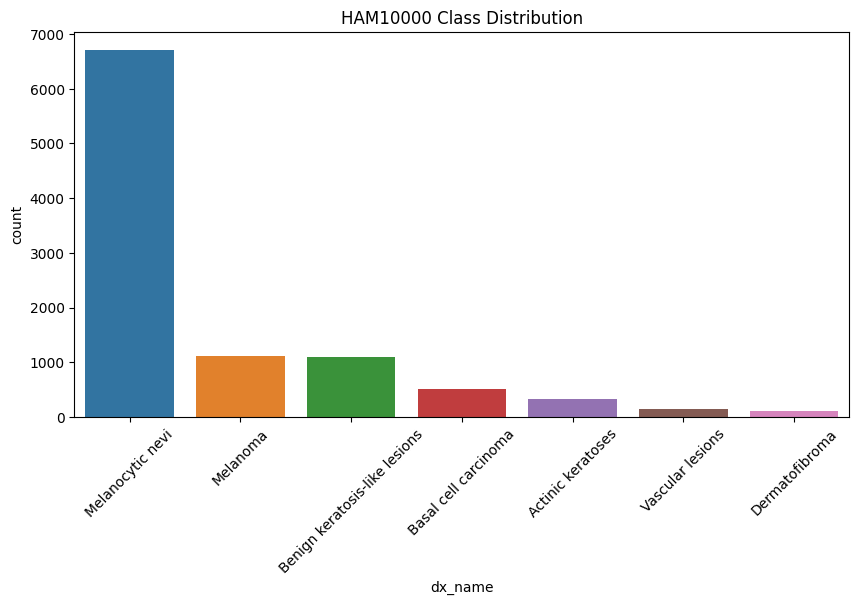

In [9]:
df['dx_name'] = df['dx'].map(class_names)

# Plot class distribution
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='dx_name', order=df['dx_name'].value_counts().index)
plt.xticks(rotation=45)
plt.title('HAM10000 Class Distribution')
plt.show()

In [11]:
# 3) Check for duplicates (image_id repeated)
dup_images = df['image_id'].duplicated().sum()
print(f"Number of duplicated image_ids: {dup_images}")

Number of duplicated image_ids: 0


In [12]:
# 4) Check lesion_id duplicates (same lesion multiple images)
lesion_counts = df['lesion_id'].value_counts()
print(f"Number of unique lesions: {len(lesion_counts)}")
print(f"Lesions with multiple images: {(lesion_counts > 1).sum()}")

Number of unique lesions: 7470
Lesions with multiple images: 1956


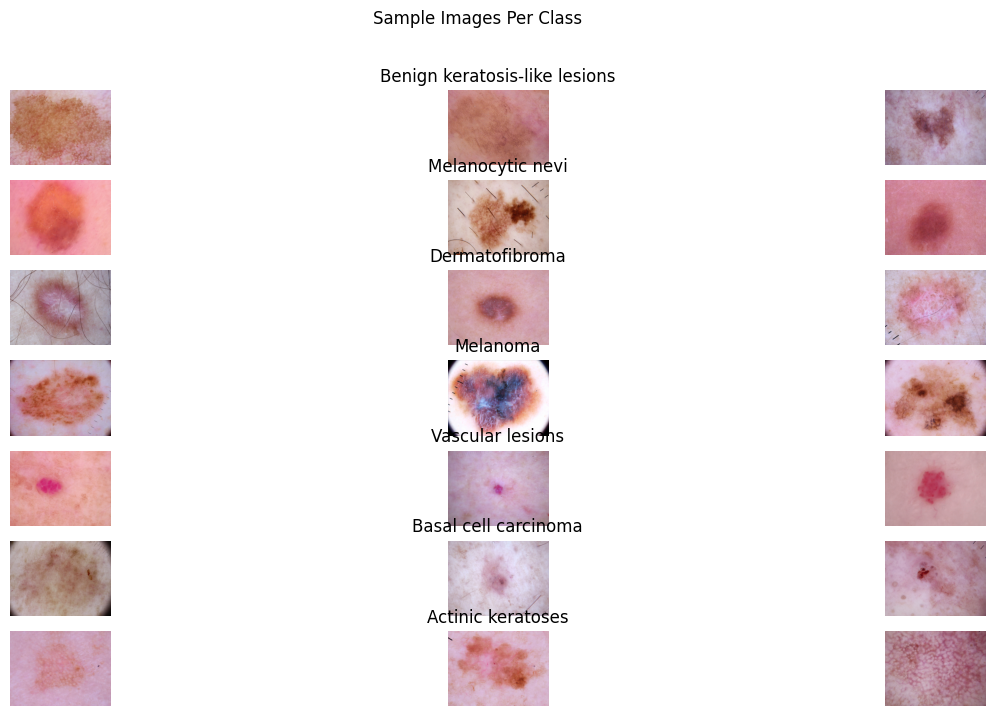

In [13]:
# 6) Visualize sample images per class
def plot_samples_per_class(df, img_dirs, samples_per_class=3):
    plt.figure(figsize=(16, 8))
    classes = df['dx'].unique()
    for i, cls in enumerate(classes):
        cls_df = df[df['dx'] == cls].sample(samples_per_class, random_state=42)
        for j, (_, row) in enumerate(cls_df.iterrows()):
            img_id = row['image_id']
            # Search image in both folders
            img_path1 = os.path.join(img_dirs[0], img_id + '.jpg')
            img_path2 = os.path.join(img_dirs[1], img_id + '.jpg')
            img_path = img_path1 if os.path.exists(img_path1) else img_path2

            img = Image.open(img_path)
            plt.subplot(len(classes), samples_per_class, i * samples_per_class + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == samples_per_class // 2:
                plt.title(class_names.get(cls, cls))
    plt.suptitle('Sample Images Per Class')
    plt.show()

plot_samples_per_class(df, [IMG_DIR1, IMG_DIR2])

In [16]:
# 7) Prepare GroupKFold splits by lesion_id (stratified by dx)
gkf = GroupKFold(n_splits=5)

df['fold'] = -1
X = df.index.values
y = df['dx'].values
groups = df['lesion_id'].values

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    df.loc[val_idx, 'fold'] = fold

print("\nFold distribution:")
print(df['fold'].value_counts())



Fold distribution:
fold
0    2003
2    2003
1    2003
3    2003
4    2003
Name: count, dtype: int64


In [17]:
OUTPUT_PATH = '/kaggle/working/ham10000_metadata_folds.csv'
df.to_csv(OUTPUT_PATH, index=False)
print(f"Saved fold assignments to {OUTPUT_PATH}")


Saved fold assignments to /kaggle/working/ham10000_metadata_folds.csv


In [18]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import numpy as np

In [19]:
# Paths
# Paths
DATA_DIR = '/kaggle/input/skin-cancer-mnist-ham10000'
IMG_DIR1 = os.path.join(DATA_DIR, 'HAM10000_images_part_1')
IMG_DIR2 = os.path.join(DATA_DIR, 'HAM10000_images_part_2')

# If folds file is generated in THIS notebook
METADATA_CSV2 = '/kaggle/working/ham10000_metadata_folds.csv'

# If folds file already exists in dataset uploaded to Kaggle
# METADATA_CSV2 = os.path.join(DATA_DIR, 'ham10000_metadata_folds.csv')




In [20]:
# Load CSV with folds (generated in Phase 1)
df = pd.read_csv(METADATA_CSV2)

In [21]:
# Map classes to indices
class_names = sorted(df['dx'].unique())
class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

print("Class to index mapping:", class_to_idx)

Class to index mapping: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [22]:
df.head(1)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_name,fold
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,0


In [23]:
# ---------------------------
# Image Transforms
# ---------------------------
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [24]:
# ---------------------------
# Dataset Class
# ---------------------------
class HAM10000Dataset(Dataset):
    def __init__(self, dataframe, img_dir1, img_dir2, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir1 = img_dir1
        self.img_dir2 = img_dir2
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_filename = row['image_id'] + '.jpg'

        img_path1 = os.path.join(self.img_dir1, img_filename)
        img_path2 = os.path.join(self.img_dir2, img_filename)

        if os.path.exists(img_path1):
            img_path = img_path1
        elif os.path.exists(img_path2):
            img_path = img_path2
        else:
            raise FileNotFoundError(f"Image {img_filename} not found in either folder.")

        image = Image.open(img_path).convert("RGB")
        label = class_to_idx[row['dx']]

        if self.transform:
            image = self.transform(image)

        return image, label

In [25]:
# ---------------------------
# Create DataLoaders
# ---------------------------
def get_dataloaders(fold, batch_size=32, use_sampler=True):
    train_df = df[df['fold'] != fold]
    val_df = df[df['fold'] == fold]

    train_dataset = HAM10000Dataset(train_df, IMG_DIR1, IMG_DIR2, transform=train_transforms)
    val_dataset = HAM10000Dataset(val_df, IMG_DIR1, IMG_DIR2, transform=val_transforms)

    if use_sampler:
        class_counts = train_df['dx'].value_counts().to_dict()
        class_weights = {cls: 1.0/count for cls, count in class_counts.items()}
        sample_weights = [class_weights[row['dx']] for _, row in train_df.iterrows()]
        sampler = WeightedRandomSampler(weights=sample_weights,
                                        num_samples=len(sample_weights),
                                        replacement=True)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [26]:
# ---------------------------
# Example: Load fold 0
# ---------------------------
train_loader, val_loader = get_dataloaders(fold=0, batch_size=32)

# Check one batch
images, labels = next(iter(train_loader))
print("Batch images shape:", images.shape)
print("Batch labels:", labels)

Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([2, 0, 1, 0, 1, 5, 1, 0, 2, 5, 6, 2, 2, 4, 3, 4, 3, 1, 0, 5, 2, 1, 3, 3,
        4, 3, 6, 6, 1, 0, 0, 5])


# **Trainign Teacher**

In [ ]:
!pip uninstall -y torch torchvision torchaudio timm
!pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu122
!pip install timm==1.0.9

In [27]:
#!pip install timm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import timm
import copy
import time

In [28]:
from torchvision import models
import os

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy

In [36]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------
# 1. Load Pretrained EfficientNet-B4
# -----------------------
num_classes = len(class_to_idx)  # from your dataset
model = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1)

# Replace classifier
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Freeze first few blocks (first 20% layers)
freeze_layers = int(0.2 * len(list(model.features.named_parameters())))
for name, param in list(model.features.named_parameters())[:freeze_layers]:
    param.requires_grad = False

model = model.to(device)

# -----------------------
# 2. Loss & Optimizer
# -----------------------
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # optional label smoothing
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=25)

# -----------------------
# 3. Training Loop with Best Model Saving
# -----------------------
epochs = 25
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
save_path = "/kaggle/working/teacher_model_best.pth"  # Kaggle output dir

for epoch in range(epochs):
    # ---- Training ----
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100. * correct / total
    scheduler.step()

    # ---- Validation ----
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100. * val_correct / val_total
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {running_loss/total:.4f} | Train Acc: {train_acc:.2f}% "
          f"Val Loss: {val_loss/val_total:.4f} | Val Acc: {val_acc:.2f}%")

    # ---- Save Best Model ----
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, save_path)
        print(f"✅ Best model updated & saved at epoch {epoch+1} with Val Acc: {val_acc:.2f}%")

# Load best model weights
model.load_state_dict(best_model_wts)


Using device: cuda


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 157MB/s] 


Epoch [1/25] Train Loss: 1.6010 | Train Acc: 44.91% Val Loss: 1.1314 | Val Acc: 61.96%
✅ Best model updated & saved at epoch 1 with Val Acc: 61.96%
Epoch [2/25] Train Loss: 0.9955 | Train Acc: 67.97% Val Loss: 1.0278 | Val Acc: 67.35%
✅ Best model updated & saved at epoch 2 with Val Acc: 67.35%
Epoch [3/25] Train Loss: 0.8398 | Train Acc: 75.22% Val Loss: 0.8729 | Val Acc: 72.94%
✅ Best model updated & saved at epoch 3 with Val Acc: 72.94%
Epoch [4/25] Train Loss: 0.7680 | Train Acc: 78.21% Val Loss: 0.8576 | Val Acc: 73.29%
✅ Best model updated & saved at epoch 4 with Val Acc: 73.29%
Epoch [5/25] Train Loss: 0.7046 | Train Acc: 81.35% Val Loss: 0.7935 | Val Acc: 76.49%
✅ Best model updated & saved at epoch 5 with Val Acc: 76.49%
Epoch [6/25] Train Loss: 0.6713 | Train Acc: 82.79% Val Loss: 0.7710 | Val Acc: 77.38%
✅ Best model updated & saved at epoch 6 with Val Acc: 77.38%
Epoch [7/25] Train Loss: 0.6162 | Train Acc: 85.20% Val Loss: 0.7714 | Val Acc: 76.93%
Epoch [8/25] Train Loss: 

<All keys matched successfully>

In [ ]:
#student modek
Loop: for i in j

In [ ]:
#why not in the cell  